### Linear and KNN models

In this notebook I will be creating a knn classification model as well as a linear regression model from our merged datasets. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

In [2]:
df = pd.read_csv("data/merged_dataset.csv")

In [3]:
df.shape

(3133, 54)

Since many datasets were used to create the merged dataframe there will be quite a few missing values that we will have to deal with. 

In [4]:
df.isnull().sum()

county                                                           0
county_fips_code                                                 0
cases                                                            0
deaths                                                           0
stname                                                           0
ctyname                                                          0
tot_pop                                                          0
deaths_per_hun_thou                                              0
cnty_name                                                        1
unemployment_rate                                                1
med_cases_per_100k_change                                        0
med_per_test_results_positive                                   18
transmission_level_high                                          0
transmission_level_low                                           0
transmission_level_moderate                                   

For the columns pertaining to beds and "pct" I will be dropping them. I don't feel that there is a reasonable way to impute these nulls. The columns pertaining to voting are all missing roughly the same rows which probably means that there was no data to collect in those counties. The remaining nulls will be dropped as they are less than 5 percent of the data.  I am also dropping all duplicate columns. Lastly the columns for county, state, and county_fips_code will be dropped as they are identifying columns and will not contribute to our modeling. 

In [5]:
# Dropping columns that I won't be using 
df.drop(columns=['total_beds_7_day_sum', 'cnty_name',
                'ctyname', 'stname', 'state', 'county', 'county_fips_code'], inplace=True)
                

In [6]:
# Dropping remaining nulls 
df.dropna(inplace=True)

In [7]:
df.shape

(2410, 47)

Looking at the chart below there does not appear to be much correlation between our target variable and a lot of our features.  

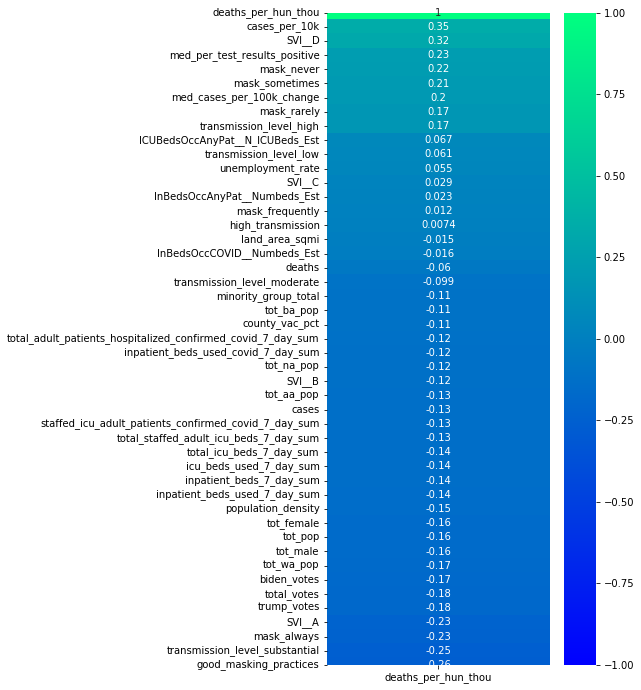

In [8]:
# Creates correlation matrix for plot
corr_matrix = df.corr()

# Plots correlation of features
plt.figure(figsize=(5, 12))
ax = sns.heatmap(corr_matrix[['deaths_per_hun_thou']]
                 .sort_values(by='deaths_per_hun_thou', ascending=False),
         annot = True,
         vmin = -1,
         vmax = 1,
         cmap = 'winter'
                
                 );

## Modeling 

For my predictions on which counties will need the most help with covid I will be using deaths_per_hun_thou as my y variable. 

### Linear Model

As there is a poor correlation between the feature deaths_per_hun_thou and the rest of our features it does not seem that a linear model is a good fit for our problem statement.

In [9]:
# baseline score 
df['deaths_per_hun_thou'].mean()

315.6987377224647

In [10]:
# Creates X variable with all columns but deaths_per_hun_thou
X = df[[col for col in df if col not in "deaths_per_hun_thou"]]

# Creates target variable
y = df['deaths_per_hun_thou']

# Instantiating linear regression
linreg = LinearRegression()




# setting cross_val_score
scores = cross_val_score(linreg,
                         X,
                         y,
                         cv=KFold(n_splits=5,
                                  shuffle=True,
                                  random_state=73))

                                                    

In [11]:
scores.mean()

0.3221382213719079

### KNN model

To use our classification model we will need to turn our deaths_per_hun_thou into a binary column. I have chosen to make this column a 1 for counties that are above the 75th percentile of deaths_per_hun_thou and a zero for those that are below. 

In [12]:
df.describe()

,cases,deaths,tot_pop,deaths_per_hun_thou,unemployment_rate,med_cases_per_100k_change,med_per_test_results_positive,transmission_level_high,transmission_level_low,transmission_level_moderate,...,SVI__B,SVI__C,SVI__D,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop,minority_group_total
count,2.410000e+03,2410.000000,2.410000e+03,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,2410.000000,...,2410.000000,2410.000000,2410.000000,2.410000e+03,2.410000e+03,2.410000e+03,2.410000e+03,2.410000e+03,2410.000000,2.410000e+03
mean,2.560172e+04,319.068050,1.271117e+05,315.698738,6.777261,131.945477,8.134239,0.536414,0.154879,0.169130,...,0.257261,0.248963,0.251452,6.260772e+04,6.450394e+04,9.755708e+04,1.667183e+04,7.441929e+03,318.488382,1.667183e+04
std,7.910304e+04,944.739841,3.681328e+05,137.132044,2.190636,55.160933,3.674113,0.076747,0.079720,0.054944,...,0.437215,0.432502,0.433938,1.811625e+05,1.870059e+05,2.642657e+05,6.216774e+04,4.793623e+04,2478.573489,6.216774e+04
min,1.630000e+02,0.000000,1.077000e+03,0.000000,1.700000,0.000000,0.000000,0.169231,0.046154,0.000000,...,0.000000,0.000000,0.000000,5.440000e+02,5.330000e+02,9.330000e+02,2.000000e+00,0.000000e+00,0.000000,2.000000e+00
25%,3.121250e+03,48.000000,1.556125e+04,220.265358,5.300000,103.014500,5.810000,0.487574,0.095858,0.132544,...,0.000000,0.000000,0.000000,7.823500e+03,7.679000e+03,1.263500e+04,2.140000e+02,8.900000e+01,7.250000,2.140000e+02
50%,7.279500e+03,111.500000,3.555900e+04,305.913229,6.600000,131.191250,7.757500,0.534911,0.139645,0.168047,...,0.000000,0.000000,0.000000,1.765450e+04,1.766250e+04,3.056350e+04,1.289500e+03,2.730000e+02,24.000000,1.289500e+03
75%,1.914350e+04,255.750000,9.729350e+04,400.100799,8.100000,166.340375,9.760000,0.583432,0.192899,0.204734,...,1.000000,0.000000,1.000000,4.785800e+04,4.907950e+04,8.031050e+04,8.499000e+03,1.392250e+03,103.750000,8.499000e+03
max,2.312272e+06,28122.000000,1.003911e+07,1102.883252,22.500000,330.865000,43.875000,0.822485,0.581065,0.360947,...,1.000000,1.000000,1.000000,4.949041e+06,5.090066e+06,7.098309e+06,1.226489e+06,1.545445e+06,93325.000000,1.226489e+06


In [13]:
# Creates binary column
df.deaths_per_hun_thou = np.where(df['deaths_per_hun_thou'] >= 405, 1, 0)

In [14]:
# baseline
1 - df.deaths_per_hun_thou.mean()

0.7634854771784232

In [15]:
# Sets up X variable for columns that have not been dropped
X = df[[col for col in df if col not in "deaths_per_hun_thou"]]

# Sets up target variable
y = df['deaths_per_hun_thou']


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 73,
                                                    stratify = y) 


# Instantiate a StandardScaler + kNN pipeline.
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Define dictionary of hyperparameters.
pipe_knn_params = {
    'ss__with_mean' : [True, False],
    'ss__with_std' : [True, False],
    'knn__weights' : ['uniform', 'distance'],
    'knn__n_neighbors' : [1, 3, 5, 10, 50],
    'knn__p' : [1, 2]
}




# Instantiate our GridSearchCV object.
pipe_knn_gridsearch = GridSearchCV(pipe_knn, 
                                 pipe_knn_params,
                                 cv=5,
                                 verbose=1)
# Fitting gridsearch
pipe_knn_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 10, 50],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance'],
                         'ss__with_mean': [True, False],
                         'ss__with_std': [True, False]},
             verbose=1)

In [16]:
X.shape

(2410, 45)

In [17]:
pipe_knn_gridsearch.best_params_

{'knn__n_neighbors': 10,
 'knn__p': 1,
 'knn__weights': 'uniform',
 'ss__with_mean': True,
 'ss__with_std': True}

In [18]:
pipe_knn_gridsearch.score(X_test, y_test)

0.7904564315352697

Our knn model has performed much better than our linear model with a .783 percent accuracy. Given that the classification model has performed much better I am going to further adjust the features that I'm using for my X variable to see if I can gain more meaningful results. To start I'm going to drop the population columns as we can naturaly infer that a higher population will of course see higher death rates. I will also be dropping the voting and minority_group_total columns as they have a low correlation with my target variable. 

In [19]:
# correlation of populations
df[[col for col in df if col.startswith("tot_")]].corr()

,tot_pop,tot_male,tot_female,tot_wa_pop,tot_ba_pop,tot_aa_pop,tot_na_pop
tot_pop,1.000000,0.999900,0.999906,0.990255,0.796028,0.838056,0.474014
tot_male,0.999900,1.000000,0.999612,0.990757,0.790405,0.840743,0.477491
tot_female,0.999906,0.999612,1.000000,0.989580,0.801324,0.835293,0.470556
tot_wa_pop,0.990255,0.990757,0.989580,1.000000,0.733446,0.798099,0.439270
tot_ba_pop,0.796028,0.790405,0.801324,0.733446,1.000000,0.538708,0.244871
tot_aa_pop,0.838056,0.840743,0.835293,0.798099,0.538708,1.000000,0.597582
tot_na_pop,0.474014,0.477491,0.470556,0.439270,0.244871,0.597582,1.000000


In [20]:
# dropping population columns
df.drop(columns=[col for col in df if col.startswith("tot_")], inplace=True)


In [21]:
# dropping voting and minority_group_total
df.drop(columns=[col for col in df if col.endswith('votes') or col.startswith('minority')], inplace=True)


In [ ]:
# Sets up X variable for columns that have not been dropped
X = df[[col for col in df if col not in "deaths_per_hun_thou"]]

# Sets up target variable
y = df['deaths_per_hun_thou']

# sets up train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 73,
                                                    stratify = y) 




# Instantiate our GridSearchCV object.
pipe_knn_gridsearch_2 = GridSearchCV(pipe_knn, 
                                 pipe_knn_params,
                                 cv=5,
                                 verbose=1)

# Fitting gridsearch
pipe_knn_gridsearch_2.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [ ]:
pipe_knn_gridsearch_2.score(X_test, y_test)

In [ ]:
pipe_knn_gridsearch_2.best_params_

### Conclusion and Recommendations

Although the KNN model provided a score of .783 accuracy this problem seems to be best answered through standard EDA and inference. However in the future to further improve upon the model I would recommend gathering more recent data when available and looking specifically into the hospitals available in each county.(Staffing, building size, occupancy)

In [ ]:
X.shape